[Description](https://leaderboard.corp.amazon.com/tasks/65)

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns



plt.rcParams["figure.figsize"] = (12,4)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score

from catboost import Pool, CatBoostRegressor

InteractiveShell.ast_node_interactivity = "all"
np.set_printoptions(precision=3)

### Read Data

In [4]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

### Features used for Prediction

In [5]:
output_column=["sale_units"]
numerical_features=["hours_sold","coupon_available_for_sale",
                    "discount_percent","sale_price",
                    "price","review_rating","total_reviews",
                    "sales_rank","brand_rating","brand_price",
                    "buying_freq","inverted_price","discount_coupon",
                   "dayofweek","dayofyear"]
categorical_features=["week_of_year","gl","hour_of_day",
                      "start_hour","brand_name_transformed",
                      "category_transformed","subcategory_transformed"]
unused_categorical_features = ["brand_name"]

prediction_columns = numerical_features + categorical_features

### Libs

In [21]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt

def get_all_column_names(df):
    return df.columns.values.tolist()


def count_distinct_values_column(df, colname):
    return pd.DataFrame(df[colname].value_counts(dropna=False)).rename(columns={0: "Count"})


def count_null_per_column(df):
    """Missing value count per column grouped by column name"""
    return pd.DataFrame(df.isnull().sum()).rename(columns={0:"# of Nulls"})

def unique_values_per_column(df):
    unique_counts = {}
    for idx in df.columns.values:
        #cnt=len(df[idx].unique())
        cnt = df[idx].nunique()
        unique_counts[idx]=cnt
    unique_ctr = pd.DataFrame([unique_counts]).T
    unique_ctr_2 = unique_ctr.rename(columns={0: '# Unique Values'})
    return unique_ctr_2


def particular_values_per_column(df,values):
    counts = {}
    for idx in df.columns.values:
        cnt=np.sum(df[idx].isin(values).values)
        counts[idx]=cnt
    ctr = pd.DataFrame([counts]).T
    ctr_2 = ctr.rename(columns={0: '# Values as %s'%values})
    return ctr_2

def get_column_datatypes(df):
    dtype = {}
    for idx in df.columns.values:
        dt = df[idx].dtype
        dtype[idx]=dt
    ctr = pd.DataFrame([dtype]).T
    ctr_2 = ctr.rename(columns={0: 'datatype'})
    return ctr_2

def column_summaries(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    particular_ctr = particular_values_per_column(df,[0])
    unique_ctr = unique_values_per_column(df)
    statistical_summary = df.describe().T
    datatypes = get_column_datatypes(df)
    skewed = pd.DataFrame(df.skew()).rename(columns={0: 'skew'})
    mis_val_table = pd.concat([mis_val, mis_val_percent, unique_ctr, particular_ctr,datatypes,skewed,statistical_summary], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% missing of Total Values'})
    return mis_val_table_ren_columns

def filter_dataframe(df,filter_columns):
    df_filtered = df
    for feature in filter_columns:
        values = filter_columns[feature]
        if(len(values)==1):
            df_filtered = df_filtered[df_filtered[feature]==values[0]]
        elif(len(values)==2):
            df_filtered = df_filtered[(df_filtered[feature]>=values[0]) & (df_filtered[feature]<=values[1])]
    return df_filtered

def filter_dataframe_percentile(df, filter_columns):
    df_filtered = df
    for feature in filter_columns:
        quantiles = filter_columns[feature]
        values = df[feature].quantile(quantiles).values
        if(len(values)==1):
            # if only one value present assume upper quantile
            df_filtered = df_filtered[df_filtered[feature]<=values[0]]
        elif(len(values)==2):
            df_filtered = df_filtered[(df_filtered[feature]>=values[0]) & (df_filtered[feature]<=values[1])]
    return df_filtered


def detect_nan_columns(df):
    columns = df.columns.values.tolist()
    for colname in columns:
        if(np.sum(np.isnan(df[colname]))>0):
            print(colname)
            
def plot_bar(df,columnx,columny,rounder):
    df[columnx+"_temp"] = df[columnx].round(rounder)
    dfr=df.groupby([columnx+"_temp"])[columny].sum()
    dfr=dfr.to_frame().reset_index()
    dfr.columns = [columnx,columny]
#     sns.barplot(x=columnx, y=columny, data=dfr,palette="Greens")
    dfr.plot.bar(columnx,columny)

### Preprocessing and Exploration
- Tree models only do splits on feature column values, they don't do any mathematical operation on combination of columns
- Feature Engineering here will involve combining columns to derive more meaning from data.

#### Discount % and day/week feature engineering
- Discount % can't be inferred by the model itself.
- weekofyear, dayofyear, dayofweek - festive season sales
- hours_sold - more hours more sales
- hour_of_day - categorical feature which specifies that particular time of day leads to better sales for certain asins

In [7]:
def add_discount_column(df):
    df["price"] = df["current_price"]
    df.loc[df["price"]<=0,"price"]=df["list_price"]
    
    df["discount"] = df["price"] - df["sale_price"]
    df["discount_percent"] = df["discount"]/(df["price"] + 1)
    
    df.loc[df["discount"]<=0,"discount"] = df["list_price"] - df["sale_price"]
    df.loc[df["discount_percent"]<=0,"discount_percent"] = df["discount"]/(df["list_price"] + 1)
    
    df.loc[df["discount"]<0,"discount"]= 0
    df.loc[df["discount_percent"]<0,"discount_percent"]= 0
    
    df["discount_percent"] = df["discount_percent"]*100
    df["discount_percent"].fillna(df["discount_percent"].mean(),inplace=True)
    df["discount"].fillna(df["discount"].mean(),inplace=True)
    df["price"].fillna(df["price"].mean(),inplace=True)
    df["list_price"].fillna(df["list_price"].mean(),inplace=True)
    
    return 

add_discount_column(df)
add_discount_column(df_test)

def add_date_days(df):
    df["start_date"] = pd.to_datetime(df["start_date"])
    df["end_date"] = pd.to_datetime(df["end_date"])
    df["dayofweek"] = df["end_date"].map(lambda x: x.dayofweek)
    df["dayofyear"] = df["end_date"].map(lambda x: x.dayofyear)
    end_hour = df["end_date"].map(lambda x: x.hour)
    start_hour = df["start_date"].map(lambda x: x.hour)
    df["hours_sold"] = end_hour - start_hour
    df["start_hour"] = start_hour
    df["hour_of_day"] = (end_hour + start_hour)/2
    df["hours_sold"] = df["hours_sold"] + (df["end_date"].map(lambda x: x.minute) - df["start_date"].map(lambda x: x.minute))/60
    df.loc[df["hours_sold"]<0,"hours_sold"] = df["hours_sold"] * -1
    df["week_of_year"] = df["start_date"].map(lambda x: x.weekofyear)
    
add_date_days(df)
add_date_days(df_test)


#### Brand Rating and brand price
- brands with avg higher rating have higher customer trust as well as more chances of discovery on website
- brands with higher avg price may have less buyers

In [8]:
def add_brand_value(df,df_test):
    dfr=df_test[["brand_name","review_rating"]].append(df[["brand_name","review_rating"]])
    dfr=dfr.groupby(["brand_name"])["review_rating"].mean()

    dfr=dfr.to_frame().reset_index()
    dfr.columns = ["brand_name","brand_rating"]
    dfj=df.join(dfr.set_index('brand_name'),on="brand_name",how='inner', rsuffix='_right')
    
    dfjt=df_test.join(dfr.set_index('brand_name'),on="brand_name",how='inner', rsuffix='_right')
    
    df["brand_rating"] = dfj["brand_rating"]
    df_test["brand_rating"] = dfjt["brand_rating"]
    
add_brand_value(df,df_test)

def add_brand_price(df,df_test):
    dfr=df_test[["brand_name","price"]].append(df[["brand_name","price"]])
    dfr=dfr.groupby(["brand_name"])["price"].mean()

    dfr=dfr.to_frame().reset_index()
    dfr.columns = ["brand_name","brand_price"]
    dfj=df.join(dfr.set_index('brand_name'),on="brand_name",how='inner', rsuffix='_right')
    
    dfjt=df_test.join(dfr.set_index('brand_name'),on="brand_name",how='inner', rsuffix='_right')
    
    df["brand_price"] = dfj["brand_price"]
    df_test["brand_price"] = dfjt["brand_price"]
    
add_brand_price(df,df_test)
    

#### Buying Freq and Inverted Price
- buying_freq is trying to predict what was the frequency of purchases of this product before the sale
- Inverting price since price has a inverse relation, a linear relation can help the model work better

In [32]:
def add_buying_frequency(df):
    df["buying_freq"] = np.sqrt((1/(df["discount_percent"] + 1))
                                * 1/((df["list_price"] + df["price"] + 1)/2) 
                                * (df["total_reviews"] +1) 
                                * (df["review_rating"]+1) 
                                * (df["coupon_available_for_sale"]+1) 
                                + 1)
    
add_buying_frequency(df)
add_buying_frequency(df_test)

def add_inverted_price(df):
    df["inverted_price"] = np.sqrt(100000/((df["list_price"] + df["price"] + 1)/2))
    
add_inverted_price(df)
add_inverted_price(df_test)

#### Label Encoding Categorical fields which had strings

In [10]:
def label_encode_field(df,df_test,field):
    df[field] = df[field].fillna('-1')
    df_test[field] = df_test[field].fillna('-1')
    brand_df = df[field].append(df_test[field])
    brand_df.fillna('-1')
    label_encoder = LabelEncoder()
    encoder = label_encoder.fit(brand_df.values)
    encoded_t=encoder.transform(df_test[field].fillna("-1").values)
    df_test[field+"_transformed"] = encoded_t
    encoded_df=encoder.transform(df[field].fillna("-1").values)
    df[field+"_transformed"] = encoded_df
 
    
label_encode_field(df,df_test,"brand_name")
label_encode_field(df,df_test,"category")
label_encode_field(df,df_test,"subcategory")


#### Discount_coupon
The sales of a product is proportional to `discount% * # of coupons available`
- if # of coupons is less then higher discount % can't give high sales

In [11]:
def add_discount_coupon(df,df_test):
    mean_coupons = df["coupon_available_for_sale"].mean() + df_test["coupon_available_for_sale"].mean()
    df["discount_coupon"] = df.apply(lambda row: ((row['discount_percent']+1)*row['coupon_available_for_sale']/mean_coupons),
                                   axis=1)
    df_test["discount_coupon"] = df_test.apply(lambda row: ((row['discount_percent']+1)*row['coupon_available_for_sale']/mean_coupons),
                                   axis=1)
add_discount_coupon(df,df_test)


#### Trying to Remove skew of Inputs
- sales_rank 

`plt.hist(df["sales_rank"],bins=100,range=[0,100000],log=True)`
- coupon_available_for_sale
- buying_freq

Removing Skew had no noteceable improvement since Tree models handle skews well inherently

In [ ]:
def log_features(df):
    df.loc[df["sales_rank"]<=1,"sales_rank"] = 1
    df["sales_rank_log"] = np.log(df["sales_rank"])
    df.loc[df["coupon_available_for_sale"]<=1,"coupon_available_for_sale"] = 1
    df["coupon_available_for_sale_log"]=np.log(df["coupon_available_for_sale"])
    df.loc[df["buying_freq"]<=1,"buying_freq"] = 1
    df["buying_freq_log"] = np.log(df["buying_freq"])
    
    
# log_features(df)
# log_features(df_test)
    

In [ ]:
column_summaries(df)


In [ ]:
column_summaries(df_test)

### EDA by Plots

# records with sale_units as 1 = 233061.000


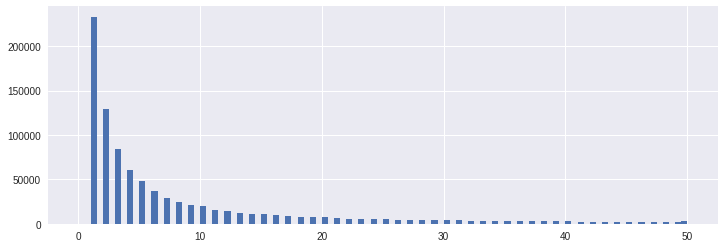

In [12]:
one_unit_sales_records_count = df[df["sale_units"]==1]["ID"].count()
print("# records with sale_units as 1 = %.3f" % one_unit_sales_records_count)
mlpto=plt.hist(df["sale_units"], range=[0, 50],bins=100)
plt.show()

#### Plots of Existing features
- discount to sale_units is an inverse relation which seems counter intuitive, mainly cause products with higher abs discount also have higher abs price
- discount % gives a linear relation

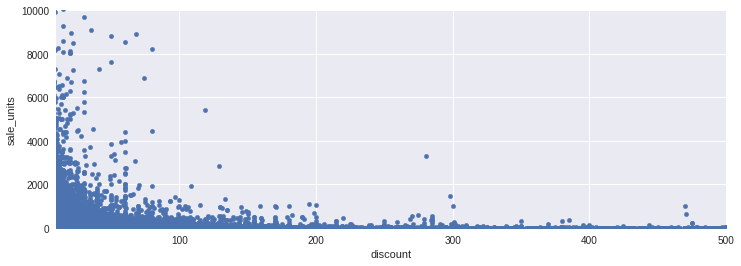

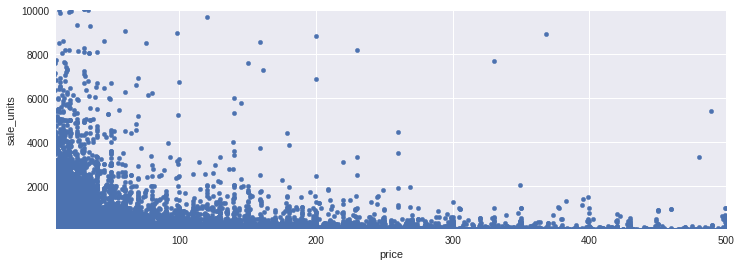

In [43]:
df.plot.scatter("discount","sale_units",xlim=[10,500],ylim=[10,10000])

df.plot.scatter("price","sale_units",xlim=[10,500],ylim=[100,10000])




- coupon_available_for_sale and sale_units are linearly related mainly cause discounts are available via coupons and once coupons are over no discounts.

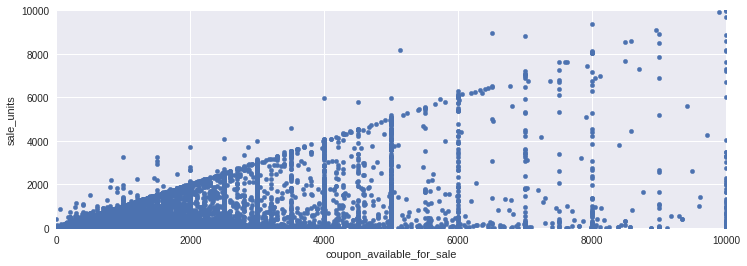

In [14]:
df.plot.scatter("coupon_available_for_sale","sale_units",xlim=[0,10000],ylim=[10,10000])


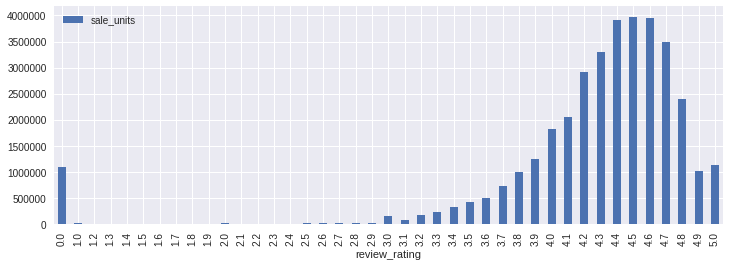

In [22]:
plot_bar(df,"review_rating","sale_units",1)

#### Plots of Engineered features

##### Time Based Features

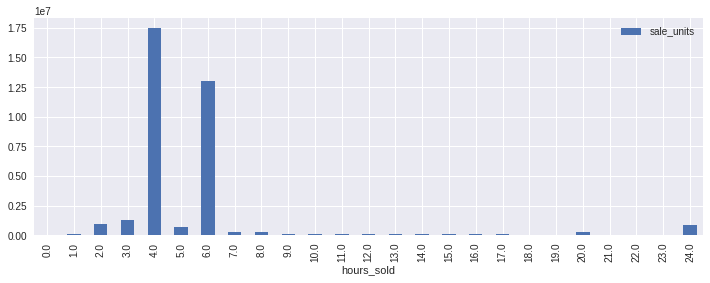

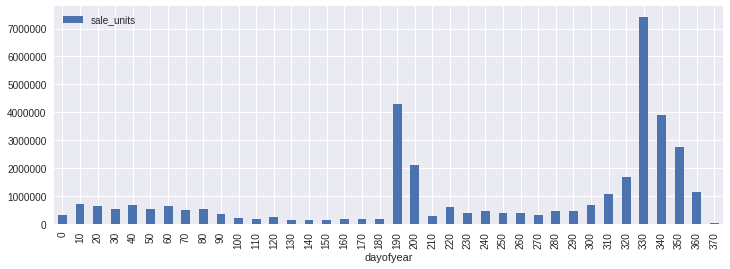

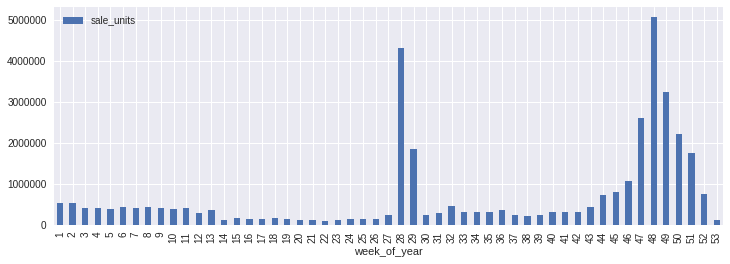

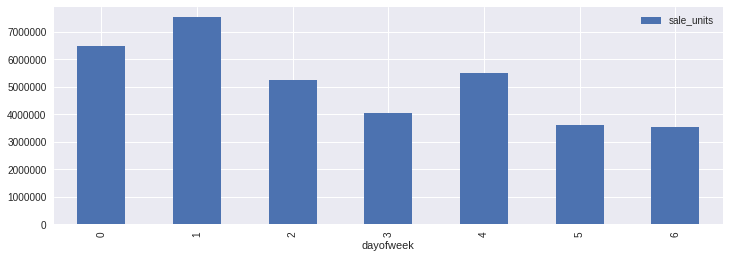

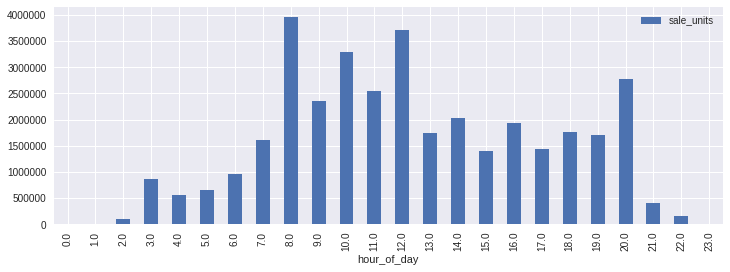

In [23]:
# df.plot.scatter("hours_sold","sale_units",xlim=[0,24],ylim=[100,10000])
plot_bar(df,"hours_sold","sale_units",0)
plot_bar(df,"dayofyear","sale_units",-1)
plot_bar(df,"week_of_year","sale_units",0)
plot_bar(df,"dayofweek","sale_units",0)
plot_bar(df,"hour_of_day","sale_units",0)

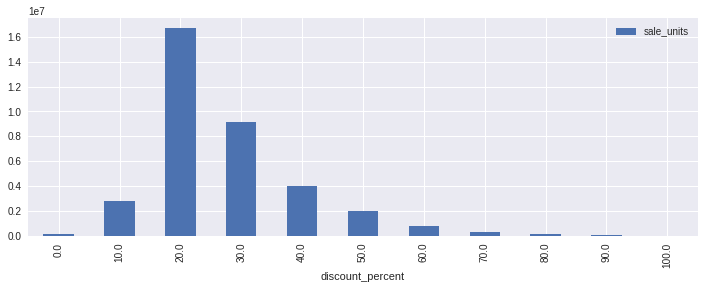

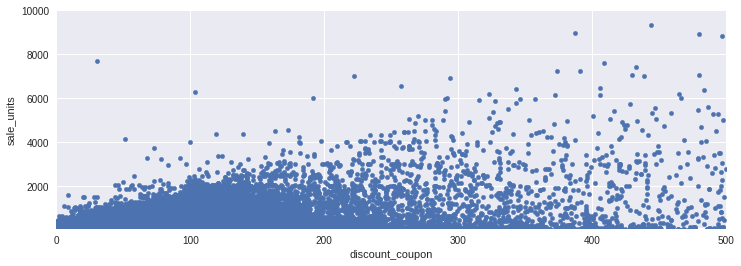

In [46]:
plot_bar(df,"discount_percent","sale_units",-1)
df.plot.scatter("discount_coupon","sale_units",xlim=[0,500],ylim=[100,10000])


#### Brand related summarised features
- brand_rating is avg rating of the brand
- brand_price is avg price of any item per brand

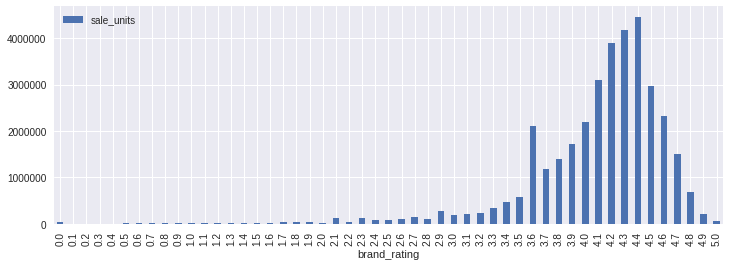

In [25]:
plot_bar(df,"brand_rating","sale_units",1)

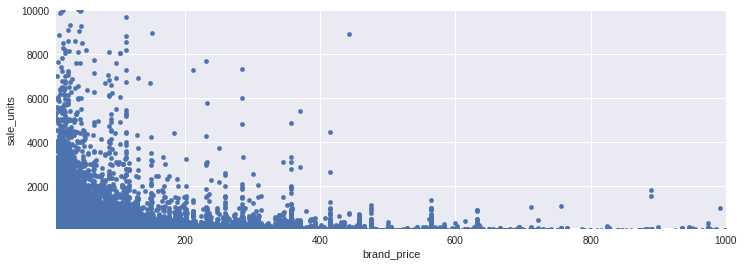

In [26]:
df.plot.scatter("brand_price","sale_units",xlim=[10,1000],ylim=[100,10000])

#### Brand name, category and subcategory

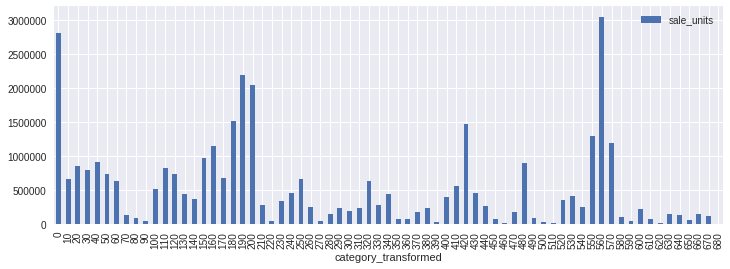

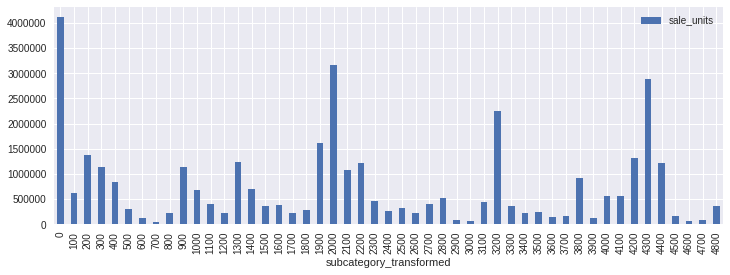

In [47]:
# df.plot.scatter("category_transformed","sale_units",ylim=[1000,10000])
plot_bar(df,"category_transformed","sale_units",-1)
# df.plot.scatter("subcategory_transformed","sale_units",ylim=[1000,10000])
plot_bar(df,"subcategory_transformed","sale_units",-2)


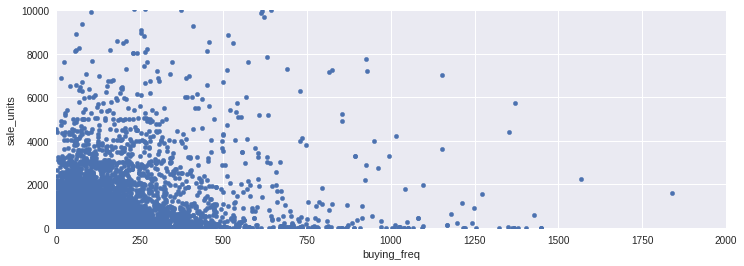

In [44]:
df.plot.scatter("buying_freq","sale_units",ylim=[10,10000],xlim=[1,2000])


### Making Prediction

In [48]:
X = df[prediction_columns].values
y = df[output_column].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

np.isnan(X).any()

True

#### XGB
- RF can't handle NaN so imputation was needed, hence xgb was a better choice as it handles NaNs

In [49]:
# param = {'max_depth':2, 'eta':1, 'silent':1, 'objective', 'reg:linear', }
# bst = xgb.train(param, dtrain, num_round)

xgr=xgb.XGBRegressor(n_estimators=200, learning_rate=0.11, gamma=0, subsample=0.75,
                           colsample_bytree=0.8, max_depth=12,nthread=16,min_child_weight=0.5,scale_pos_weight=5)
xgr.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.11, max_delta_step=0,
       max_depth=12, min_child_weight=0.5, missing=None, n_estimators=200,
       n_jobs=1, nthread=16, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=5, seed=None,
       silent=True, subsample=0.75)

In [50]:
def use_model_for_testing(model,X_train,y_train,X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print("Train MSE: %.3f" % mean_squared_error(y_pred_train, y_train))
    print("TEST MSE: %.3f" % mean_squared_error(y_test, y_pred))
    print("Train RMSE: %.3f" % mean_squared_error(y_pred_train, y_train)**0.5)
    print("TEST RMSE: %.3f" % mean_squared_error(y_test, y_pred)**0.5)
    print(explained_variance_score(y_pred_train,y_train))
    print(explained_variance_score(y_pred,y_test))
    return

use_model_for_testing(xgr,X_train,y_train,X_test,y_test)

Train MSE: 1795.320
TEST MSE: 22424.706
Train RMSE: 42.371
TEST RMSE: 149.749
0.986927043206
0.0940210332272


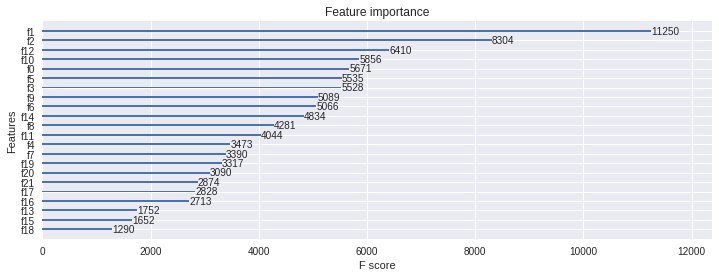

,feature,importance
0,hours_sold,5.772186
1,coupon_available_for_sale,11.450731
2,discount_percent,8.452167
3,sale_price,5.626635
4,price,3.534968
5,review_rating,5.633760
6,total_reviews,5.156392
7,sales_rank,3.450487
8,brand_rating,4.357385
9,brand_price,5.179802


In [51]:
from xgboost import plot_importance
plot_importance(xgr)
plt.show()
fi=xgr.feature_importances_

fn=df[prediction_columns].columns.values

df_i=pd.DataFrame({"feature":fn,"importance":fi})
df_i["importance"] = df_i["importance"]*100
df_i.head(25)

In [ ]:
param_test1 = {
 'max_depth':[8,10],
 'min_child_weight':[1,2,4]
 'n_estimators':[4000,5000]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBRegressor(n_estimators=5000, learning_rate=0.05, gamma=0, subsample=0.75,
                           colsample_bytree=0.8, max_depth=10,nthread=16,min_child_weight=2), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False)
gsearch1.fit(X_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

#### CatBoost - Unsuccessful

In [ ]:


    
def cat_transform_dataframe(df,prediction_columns):
    df_cat = df[prediction_columns].copy(deep=True)
    float_list = list(df_cat[prediction_columns].select_dtypes(include=['float64','object']).columns)
    for c in float_list:
        df_cat[c] = df_cat[c].apply(str)
    
    
    return df_cat

df_cat = cat_transform_dataframe(df,["price","hours_sold"])
df_cat = pd.concat([df_cat,df[output_column]],axis=1)
df_test_cat = cat_transform_dataframe(df_test,["price","hours_sold"])

X_cat = df_cat[["price","hours_sold"]].values
y_cat = df_cat[output_column].values

cat_features = [0]
X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.2)

train_pool = Pool(X_cat_train.tolist(), y_cat_train.tolist(), cat_features)
test_pool = Pool(X_cat_test, cat_features)

    



### Predict for actual Test Set

In [ ]:
def predict_and_store(model,df_test,filename,columns):
    X_t = df_test[columns].values
    y_t = model.predict(X_t)
    ids =np.array(df_test["ID"]).astype(int)
    my_solution = pd.DataFrame(y_t, ids, columns = ["sale_units"])
    print(my_solution.shape)
    my_solution.to_csv(filename, index_label = ["ID"])
    
predict_and_store(xgr,df_test,"results-5.csv",prediction_columns)

### Params used for winning

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=16, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

### Improvements
- Lots of inter-dependent variables were fed to model, this can be changed, interdependent vars can be removed n model retested
- Label encoding categorical features assumes ordinal relation, this is not true for category,brand etc variables. One hot or Hash encoding can be looked into.
- Error metric could be RMSLE instead of RMSE.
- buying_freq can be improved by taking GL,category,sub-cat into account, even asin's past sales can be taken from external sources
- outlier Removal on both items with extreme sale_units and high discount %, these could be one off sales or product launches and are not repeatable events, unless we know what kind of sale it was these data could be outliers